In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import mpld3
from statsmodels.tsa.api import SimpleExpSmoothing
from sksurv.linear_model import CoxPHSurvivalAnalysis
mpld3.enable_notebook()

In [2]:
#Read Data frame
df_original = pd.read_csv('SteamCharts.csv')
df = df_original.copy()

/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,27,29,31,52,67,111) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Replace nan with -1
df = df.replace(np.nan,-1)

#Select peak players from df
df = df.loc[df['Peak_Players'] == 1]

In [4]:
#Convert values to floats
df.columns.values[6:]
for i in df.columns.values[6:]:
    df[i]=df[i].astype(float)

In [5]:
#More data treatment
lista = []
minimum_peak = 100
for i in df.index:
    if (df.loc[i].values[6:].max() == 0) or (df.loc[i].values[6:].max() < minimum_peak):
        lista.append(i)

df = df.drop(lista)
df = df.drop(df.loc[df['April 2021'] == -1].index)
df = df.rename(columns={"Last 30 Days": "May 2021"}, errors="raise")

In [6]:
#Exponential fit on data
#This block replaces the values of the df with new exponential fit


df_dummy_right = df.drop(columns = ['Name', 'App_id', 'Avg_Players', 'Gain', 'Perc_Gain', 'Peak_Players']).copy()
df_dummy_left = df.drop(columns = df.columns[6:]).copy()


def Reverse(lst):
    return [ele for ele in reversed(lst)]


for index in df_dummy_right.index:
    
    a = list(df_dummy_right.loc[index])
    b = np.arange(0,len(a))
    arr = np.array(Reverse(a))
    ses = SimpleExpSmoothing(arr)
    fit = ses.fit(smoothing_level = .3 , optimized=False)
    fitlist = list(fit.fittedvalues)
    fitlistrev = Reverse(fitlist)
    df_dummy_right.loc[index] = fitlistrev



df = pd.concat([df_dummy_left, df_dummy_right], axis=1)




/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [7]:
#Find how long it takes to reach maximum

def days_to_glory(index):
#Find when it was released
    c = 0
    flag = False
    for i in list(df.loc[index].values):
        if (type(i) == type(np.array([.1])[0])):
            if i < 0:
                release =  pd.Timestamp(df.columns[c-1]) 
                flag = True
                break
        c +=1
    if flag == False:
        release = pd.Timestamp(df.columns[-1]) 
#Find when it reached maximum
    c = -1 
    for i in reversed(list(df.loc[index].values)):
        if i == df.loc[index].values[6:].max():
       
            maximum = pd.Timestamp(df.columns[c])
            break
        c -= 1
    
    x = str(maximum - release)
    return float(x.split(' ')[0])


In [8]:
#Find how long it takes to reach 10% once maximum is reached

perc = .10 #This number controls the percentage desired

def life_time(index):
    c = -1 
    for i in reversed(list(df.loc[index].values)):
        if i == df.loc[index].values[6:].max():
    
            maximum = pd.Timestamp(df.columns[c])
            break
        c -= 1 
    trunc = df.loc[index].values[:(c+len(df.loc[index].values))]
    trunc = trunc[6:]
    d = -1 
    flag = False
    for i in reversed(list(trunc)):        
        if i <= df.loc[index].values[6:].max()*perc:  
            death = pd.Timestamp(df.columns[d+c])
            flag = True
            break
        d -= 1 
    if flag == False:
        x = str(pd.Timestamp('May 2021') - maximum)
        return float(x.split(' ')[0]) , False
    else:
        x = str(death - maximum)
        return float(x.split(' ')[0]) , True


In [9]:

days = [] #Days to reach maximum
games_alive = [] #Games that are "alive", which are the games that have not died by May 2021
bad_index = [] #Index of games that miss data
c = 0
for index in df.index:
    #print(c/len(df.index)*100)
    c += 1
    if days_to_glory(index) >= 0:
        days.append(days_to_glory(index))
    if days_to_glory(index) == 0:
        games_alive.append(index)
    if days_to_glory(index) < 0:
        bad_index.append(index)
    
df = df.drop(bad_index)


In [10]:
df

,Name,App_id,Avg_Players,Gain,Perc_Gain,Peak_Players,May 2021,April 2021,March 2021,February 2021,...,April 2013,March 2013,February 2013,January 2013,December 2012,November 2012,October 2012,September 2012,August 2012,July 2012
3,Counter-Strike: Global Offensive,730,0.0,0.0,0.0,1.0,1.126845e+06,1.117745e+06,1.083101e+06,1.065794e+06,...,31844.380992,31706.544274,30193.063249,29693.37607,30610.6801,22072.543,22596.49,16827.7,1642.0,1642.0
7,Dota 2,570,0.0,0.0,0.0,1.0,6.847081e+05,6.757827e+05,6.873146e+05,7.026145e+05,...,249714.262125,217192.660179,188616.657398,157599.93914,133633.7702,118206.386,95211.98,85135.4,75041.0,75041.0
11,PLAYERUNKNOWN'S BATTLEGROUNDS,578080,0.0,0.0,0.0,1.0,4.546776e+05,4.551484e+05,4.511491e+05,4.527601e+05,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0
15,Apex Legends,1172470,0.0,0.0,0.0,1.0,1.695713e+05,1.489328e+05,1.148587e+05,7.974139e+04,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0
19,Team Fortress 2,440,0.0,0.0,0.0,1.0,1.180515e+05,1.176664e+05,1.196204e+05,1.136205e+05,...,76564.430853,78178.186932,80443.267046,83076.09578,87096.5654,89714.522,82369.46,78999.8,62321.0,62321.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49611,Village Story,601280,0.0,0.0,0.0,1.0,2.553071e+02,2.361531e+02,2.092187e+02,1.720266e+02,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0
49623,Cereal Soup,838900,0.0,0.0,0.0,1.0,6.935038e+00,7.335769e+00,5.336813e+00,8.052590e+00,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0
49799,Transmissions: Element 120,365300,0.0,0.0,0.0,1.0,1.662111e+01,1.903016e+01,2.032880e+01,2.132686e+01,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0
50039,Soulfire,822800,0.0,0.0,0.0,1.0,1.819080e+01,2.427257e+01,3.167511e+01,4.310729e+01,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.0000,-1.000,-1.00,-1.0,-1.0,-1.0


In [11]:
life = [] #How long the games last to reach the desired percentage
#False means alive
status = []
c = 0
for index in df.index:
    #print(c/len(df.index)*100)
    life.append(life_time(index)[0])
    status.append(life_time(index)[1])
    c += 1


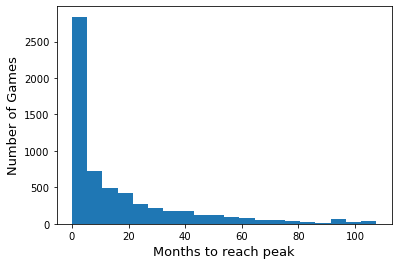

In [12]:
#Histogram 1

months = np.array(days)/30
plt.hist(months,20)
plt.xlabel('Months to reach peak', fontsize = 13)
plt.ylabel('Number of Games', fontsize = 13)

plt.savefig('reach_peak.png')
plt.show()

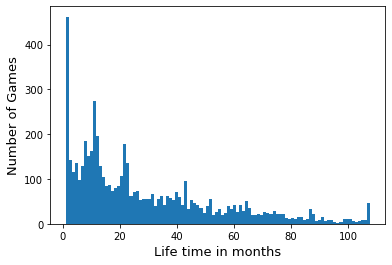

In [13]:
# Histogram 2
life = np.array(life)
plt.hist(life[life>0]/30,100,)
plt.xlabel('Life time in months', fontsize = 13)
plt.ylabel('Number of Games', fontsize = 13)
plt.savefig('life_time.png')
plt.show()

In [14]:
lofe = life/30
lofe = lofe[lofe>6]
lofe = lofe[lofe>0]
print('The total number of games that died after 6 months is ', len(lofe))

The total number of games that died after 6 months is  4718


In [15]:
lofe = life/30
lofe = lofe[lofe<=6]
lofe = lofe[lofe>0]
print('The total number of games that died before 6 months is ', len(lofe))

The total number of games that died before 6 months is  856


In [16]:
print('the number of games alive containing at least peak ', minimum_peak, 'is ', len(games_alive))

#### app id for the games
block_busters = df.loc[games_alive]


the number of games alive containing at least peak  100 is  881


In [17]:
#Status: if status is True, it means that the game died. If it is False, it means that the game is still alive.

df['Status'] = status
df['Life_time'] = life
df['Days_to_glory'] = days

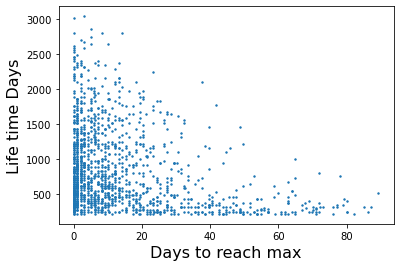

In [18]:
# Scatter Plot
temp = df.loc[ df['Status'] == True ][['Days_to_glory','Life_time']]
plt.scatter(temp['Days_to_glory']/30, temp['Life_time'], s = 2)
plt.xlabel("Days to reach max", fontsize = 16)
plt.ylabel("Life time Days", fontsize = 16)
plt.show()

/Users/eduardomedina/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


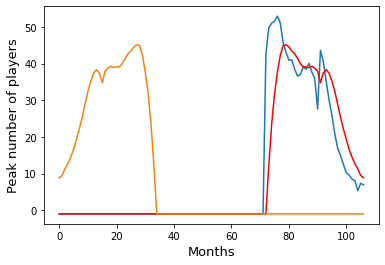

In [19]:
#Example of how fitted data looks
    
a = list(df_dummy_right.loc[3])
b = np.arange(0,len(a))
arr = np.array(Reverse(a))
ses = SimpleExpSmoothing(arr)
fit = ses.fit(smoothing_level = .3 , optimized=False)
fitlist = list(fit.fittedvalues)
fitlistrev = Reverse(fitlist)



pd.concat([df_dummy_left, df_dummy_right], axis=1)



plt.plot(b,Reverse(a))

plt.plot(b, fit.fittedvalues,'r-', label = "Fitted Values")

plt.plot(b,fitlistrev)

plt.xlabel('Months', fontsize = 13)
plt.ylabel('Peak number of players', fontsize = 13)


plt.show()

## Survival  Probability

In [20]:
data_y = df[['App_id','Status','Life_time']]

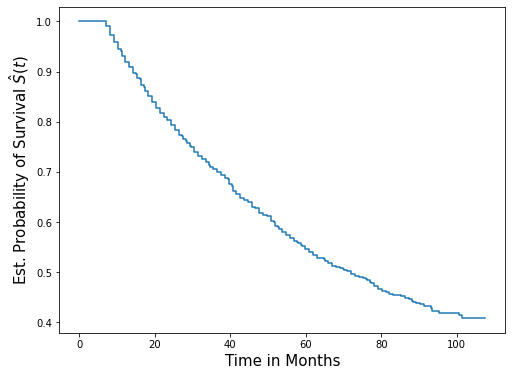

In [21]:
#Please follow https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html for more
#information for the upcoming estimators.

#Use Kaplan Meier Estimator to calculate survival probability using only the survival times and status.

from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(data_y["Status"], data_y["Life_time"]/30)


plt.figure(figsize=(8,6))


plt.step(time, survival_prob, where="post")
plt.ylabel("Est. Probability of Survival $\hat{S}(t)$",  fontsize = 15)
plt.xlabel("Time in Months", fontsize = 15)
plt.savefig('surv.jpg')
plt.show()

In [22]:
#Bring data frame with features
all_data_original = pd.read_csv('AllData.csv')
all_data_dummy = all_data_original.copy()

#Convert Categorical data to numeric data
for i in all_data_dummy.columns[19:54]:
    all_data_dummy[i] = all_data_dummy[i].astype(int)

print('the original number of games for all data was ',len(all_data_original))

the original number of games for all data was  10576


In [23]:
#Merge to match games from life times
app_id = df['App_id']
all_data = all_data_dummy.merge(app_id, how = 'inner', on = 'App_id')


In [24]:
#Make data_x

#Drop non numeric data
data_x = all_data.drop(columns = ['App_id', 'Name', 'ReleaseDate', 'SteamSpyOwners', 'SteamSpyOwnersVariance',
                         'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency', 
                         'SupportEmail','SupportURL', 'AboutText','Background', 'ShortDescrip', 
                         'DetailedDescrip', 'DRMNotice','ExtUserAcctNotice', 'HeaderImage', 
                         'LegalNotice', 'Reviews','SupportedLanguages', 'Website', 'PCMinReqsText', 
                         'PCRecReqsText','LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText', 
                         'MacRecReqsText'])

data_x = data_x.drop(columns=[ 'PlatformWindows', 'PlatformLinux', 'PlatformMac', 'SteamSpyOwnersNew',
                              'peak_max', 'peak_mean', 'max', 'mean'])




In [25]:
data_y  = data_y.merge(all_data, how = 'right', on = 'App_id')
data_y = data_y[['Status','Life_time']]


# Change format of data_y to structural array
struc = []
for i in data_y.values:
    struc.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc = np.array(struc, dtype = dt)


In [26]:
#new data frame to be used for cross validation. 
cvdf = data_x.copy()
cvdf['Status'] = data_y['Status']
cvdf['Life_time'] = data_y['Life_time']

cvdf_train = cvdf.sample(int(len(cvdf)*.75)).copy()
cvdf_test= cvdf.drop(cvdf_train.index).copy()




In [27]:
#Cross validation to find optimal regularization (alpha)

from sklearn.base import clone
from sklearn.model_selection import KFold



estimator = CoxPHSurvivalAnalysis()

alpha_val = np.arange(0,30)

scores = np.empty((3,len(alpha_val)))



def get_X_y(df,features,target):
    # Returns X then y
    return np.array(df[features]), np.array(df[target])

kfold = KFold(n_splits = 3, shuffle = True, random_state = 440)


i = 0

for train_index, test_index in kfold.split(cvdf_train):
## For each possible model
    ## get X and y
    
    for j in range(len(alpha_val)):
    
        X, y = get_X_y(cvdf_train, cvdf_train.columns[:46], ['Status','Life_time'])


        # Get the cv train test split
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        struc_train = []
        for k in y_train:
            struc_train.append((k[0],k[1]))
        dt = np.dtype('bool,float')
        struc_train = np.array(struc_train, dtype = dt)

        struc_test = []
        for k in y_test:
            struc_test.append((k[0],k[1]))
        dt = np.dtype('bool,float')
        struc_test = np.array(struc_test, dtype = dt)

        # Cloning the regression makes a fresh regression 
        # model for each run
        clone_estimator = clone(estimator)

        estimator = CoxPHSurvivalAnalysis(alpha = j)


        # fit the model
        clone_estimator.fit(X_train, struc_train)

        clone_estimator.score(X_test, struc_test)

        scores[i,j] = clone_estimator.score(X_test, struc_test)

    
    ## We'll now move to the next split
    i = i + 1



In [28]:
# Find optimal regularization
np.argmax(np.mean(scores, axis = 0))

print("The model with the highest score CV ",
     "was the one with alpha = ", alpha_val[np.argmax(np.mean(scores, axis = 0))],
     ". This model had a score CV of", np.round(np.max(np.mean(scores, axis=0)),5))


The model with the highest score CV  was the one with alpha =  1 . This model had a score CV of 0.62727


In [29]:
#Fit using optimal regularization
from sksurv.linear_model import CoxPHSurvivalAnalysis

estimator = CoxPHSurvivalAnalysis(alpha = alpha_val[np.argmax(np.mean(scores, axis = 0))])

struc_train = []
for i in cvdf_train[['Status','Life_time']].values:
    struc_train.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc_train = np.array(struc_train, dtype = dt)


estimator.fit(cvdf_train[cvdf_train.columns[:46]], struc_train)



CoxPHSurvivalAnalysis(alpha=1)

In [30]:
# The value of these coefficients tell us the weight of each feature and their impact.
# Coeff > 0 contributes to decrease the probaility of survival
# Coeff < 0 increases probability of survival
pd.Series(estimator.coef_, index=data_x.columns)


RequiredAge                   -0.003751
DemoCount                     -0.169543
DeveloperCount                 0.015548
DLCCount                      -0.000522
Metacritic                    -0.000277
MovieCount                     0.059025
PackageCount                   0.053707
RecommendationCount           -0.000006
PublisherCount                -0.419864
ScreenshotCount               -0.001245
AchievementCount               0.000092
AchievementHighlightedCount    0.020022
ControllerSupport             -0.003062
IsFree                         0.037336
FreeVerAvail                   1.005102
PurchaseAvail                 -0.284806
SubscriptionAvail             -0.542178
PCReqsHaveMin                 -0.741028
PCReqsHaveRec                  0.173654
LinuxReqsHaveMin               0.224075
LinuxReqsHaveRec              -0.171551
MacReqsHaveMin                -0.054737
MacReqsHaveRec                -0.183464
CategorySinglePlayer          -0.269872
CategoryMultiplayer           -0.136655


In [31]:
# Calculate score for perfomance

struc_test = []
for i in cvdf_test[['Status','Life_time']].values:
    struc_test.append((i[0],i[1]))
dt = np.dtype('bool,float')
struc_test = np.array(struc_test, dtype = dt)


print(estimator.score(cvdf_test[cvdf_train.columns[:46]], struc_test))




0.5854302120450378


In [32]:
# How predictive is each parameter

import numpy as np

def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, struc)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

GenreIsIndie                   0.564442
PriceInitial                   0.557392
PriceFinal                     0.557153
GenreIsAction                  0.539849
GenreIsCasual                  0.532985
ScreenshotCount                0.528125
Metacritic                     0.523005
GenreIsAdventure               0.522566
GenreIsSimulation              0.520972
RecommendationCount            0.519114
ControllerSupport              0.519104
CategoryMultiplayer            0.518681
GenreIsStrategy                0.518491
PublisherCount                 0.517067
CategoryMMO                    0.513904
DLCCount                       0.512462
GenreIsRPG                     0.512291
GenreIsFreeToPlay              0.512222
RequiredAge                    0.511233
MacReqsHaveRec                 0.510205
LinuxReqsHaveRec               0.509316
LinuxReqsHaveMin               0.508913
GenreIsMassivelyMultiplayer    0.508858
CategoryIncludeLevelEditor     0.508576
AchievementHighlightedCount    0.508070
